In [255]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR, NuSVR
# from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Perceptron
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from xgboost import XGBRegressor, XGBRFRegressor
import time
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [256]:
MODELS = {DecisionTreeRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, SVR, NuSVR,
          LinearRegression, BayesianRidge, KNeighborsRegressor, XGBRegressor, XGBRFRegressor, RadiusNeighborsRegressor,
          ElasticNet, SGDRegressor, KernelRidge, LassoLars, Lasso, Perceptron, }

In [257]:
housing = pd.read_csv(r'./datasets/kc_house_data.csv').sample(5000)
quality = pd.read_csv(r'./datasets/winequality-red.csv')

In [258]:
housing

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21012,7853400220,20140926T000000,589410.0,3,3.0,2840,7201,2.0,0,0,...,9,2840,0,2014,0,98065,47.5165,-121.883,2540,5260
5696,7691800020,20140709T000000,660000.0,4,2.5,2510,4543,2.0,0,0,...,8,2510,0,2002,0,98075,47.5962,-122.039,2550,4675
20037,2051200436,20140820T000000,692000.0,3,2.5,3490,28213,1.5,0,2,...,9,2242,1248,2009,0,98070,47.3650,-122.456,2120,56628
21410,7852120180,20150304T000000,695000.0,4,3.5,3510,9084,2.0,0,0,...,10,3510,0,2001,0,98065,47.5402,-121.875,3690,9568
6605,9284801845,20140805T000000,354000.0,3,1.5,1060,5750,1.0,0,2,...,7,1060,0,1981,0,98126,47.5512,-122.371,1060,5750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031,2946000590,20141223T000000,276000.0,3,1.5,1820,8750,1.0,0,0,...,7,1200,620,1958,0,98198,47.4213,-122.322,1500,8000
16434,4452300130,20140522T000000,677000.0,3,2.0,2000,3207,1.0,0,0,...,7,1100,900,1916,0,98103,47.6561,-122.341,1460,3200
5166,1853081060,20150416T000000,878000.0,4,2.5,3810,7728,2.0,0,0,...,9,3810,0,2007,0,98074,47.5925,-122.058,3290,7728
206,9526600140,20140919T000000,677900.0,3,2.5,2440,4587,2.0,0,0,...,8,2440,0,2010,0,98052,47.7073,-122.114,2750,4587


In [259]:
quality

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [260]:
housing = housing.dropna()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 21012 to 17575
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5000 non-null   int64  
 1   date           5000 non-null   object 
 2   price          5000 non-null   float64
 3   bedrooms       5000 non-null   int64  
 4   bathrooms      5000 non-null   float64
 5   sqft_living    5000 non-null   int64  
 6   sqft_lot       5000 non-null   int64  
 7   floors         5000 non-null   float64
 8   waterfront     5000 non-null   int64  
 9   view           5000 non-null   int64  
 10  condition      5000 non-null   int64  
 11  grade          5000 non-null   int64  
 12  sqft_above     5000 non-null   int64  
 13  sqft_basement  5000 non-null   int64  
 14  yr_built       5000 non-null   int64  
 15  yr_renovated   5000 non-null   int64  
 16  zipcode        5000 non-null   int64  
 17  lat            5000 non-null   float64
 18  lon

In [261]:
quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [276]:
def metrics(tt, tp, vt, vp, model, 
            time=None): return {
    "model": model,
    'time': time,
    "mse": (mean_squared_error(tt, tp),
            mean_squared_error(vt, vp)),
    'r2': (r2_score(tt, tp),
           r2_score(vt, vp))
}


def create_model(X, y, model_name, 
                 time_it: bool=False):
    model = Pipeline([
        ('scaler1', RobustScaler()),
        ('scaler2', MinMaxScaler()),
        ('model', model_name())
    ])
    if time_it == True:
        begin = time.time()
        model.fit(X, y)
        end = time.time()
        return (model, end - begin)
    return model.fit(X, y)


def get_metrics(X, y, model_name):
    Xt, Xv, yt, yv = train_test_split(
        X, y, train_size=.7)
    results = create_model(Xt, yt, model_name, time_it=True)
    model, time = results[0], results[1]
    return metrics(
        yt, model.predict(Xt), yv, 
        model.predict(Xv), model_name, time)
    
    
def get_results(X, y, models):
    results = []
    for i in models:
        try:results.append(get_metrics(X, y, i))
        except:pass
    return results


def plot_results(results: 'list[dict]'):
    y = [i['model'] for i in results]
    pos = np.arange(len(y))
    plt.barh(pos, [i['mse'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Validation')
    plt.show()
    plt.barh(pos, [i['mse'][0] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Traning')
    plt.show()
    plt.barh(pos, [i['time'] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Time')
    plt.show()
    plt.barh(pos, [i['r2'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('R2')
    plt.show()
    plt.barh(pos, [i['time'] * i['mse'][1] * -1 for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Efficiency (Higher the better)')
    plt.show()
    plt.barh(pos, [-1 * i['time'] * i['mse'][1] / (i['mse'][1] - i['mse'][0]) for i in results], align='center')
    plt.yticks(pos, y)
    plt.title('Weighted Efficiency (Higher the better)')
    plt.show()

In [277]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 21012 to 17575
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5000 non-null   int64  
 1   date           5000 non-null   object 
 2   price          5000 non-null   float64
 3   bedrooms       5000 non-null   int64  
 4   bathrooms      5000 non-null   float64
 5   sqft_living    5000 non-null   int64  
 6   sqft_lot       5000 non-null   int64  
 7   floors         5000 non-null   float64
 8   waterfront     5000 non-null   int64  
 9   view           5000 non-null   int64  
 10  condition      5000 non-null   int64  
 11  grade          5000 non-null   int64  
 12  sqft_above     5000 non-null   int64  
 13  sqft_basement  5000 non-null   int64  
 14  yr_built       5000 non-null   int64  
 15  yr_renovated   5000 non-null   int64  
 16  zipcode        5000 non-null   int64  
 17  lat            5000 non-null   float64
 18  lon

In [278]:
quality_X =  quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode', 
            'lat', 'long', 'price'], axis=1)
housing_y = housing['price']

In [279]:
housing_y

21012    589410.0
5696     660000.0
20037    692000.0
21410    695000.0
6605     354000.0
           ...   
4031     276000.0
16434    677000.0
5166     878000.0
206      677900.0
17575    763000.0
Name: price, Length: 5000, dtype: float64

In [280]:
quality_results, housing_results = get_results(
    quality_X, quality_y, MODELS), get_results(
    housing_X, housing_y, MODELS)

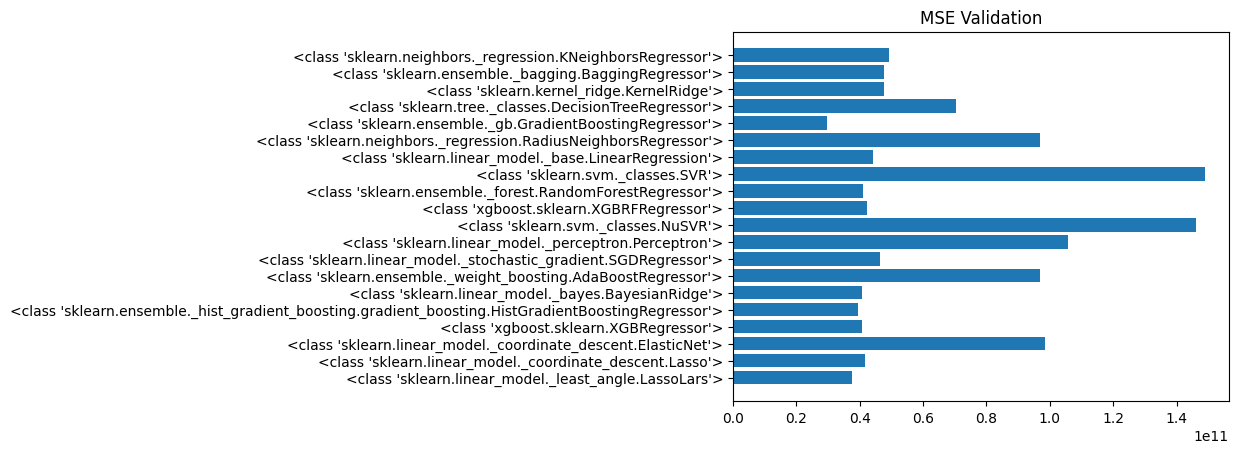

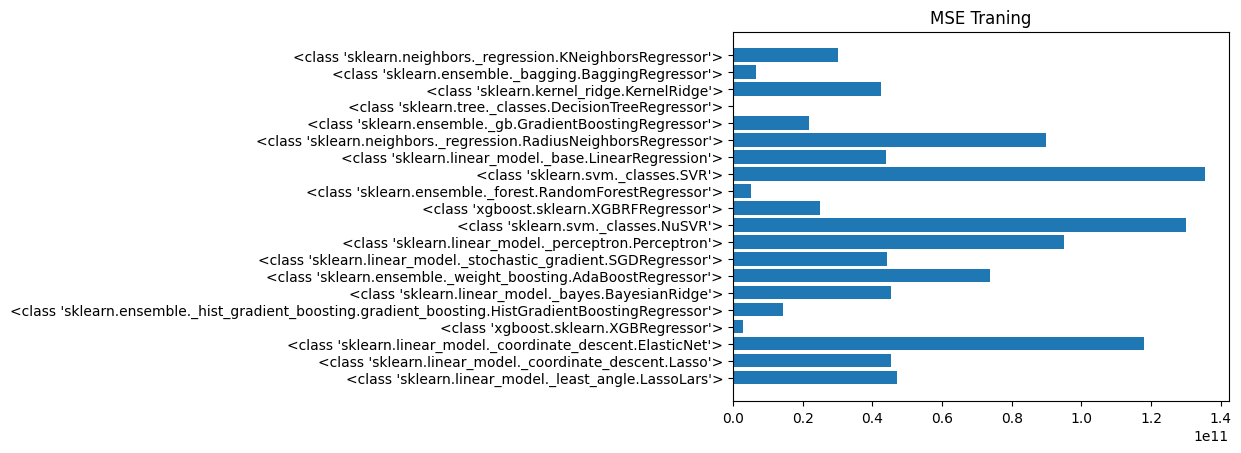

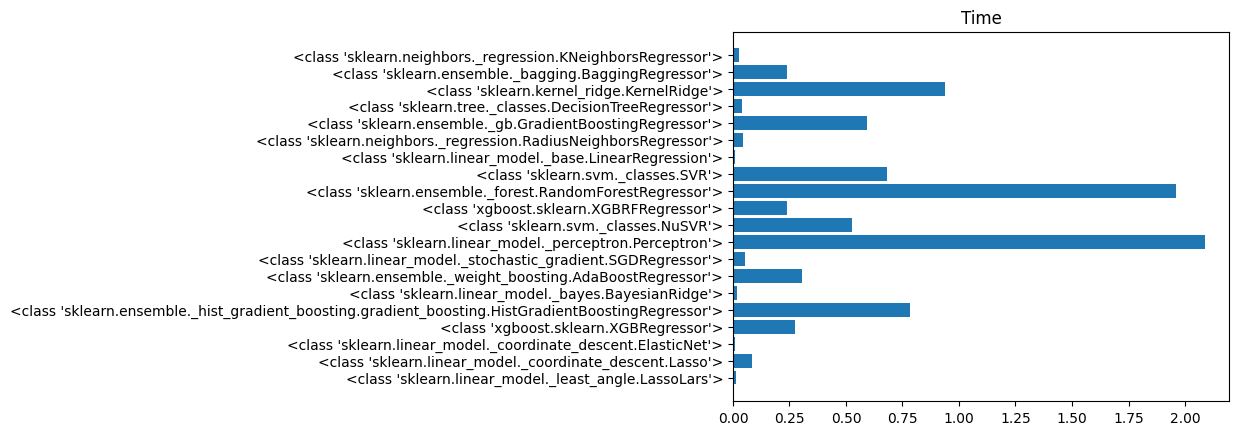

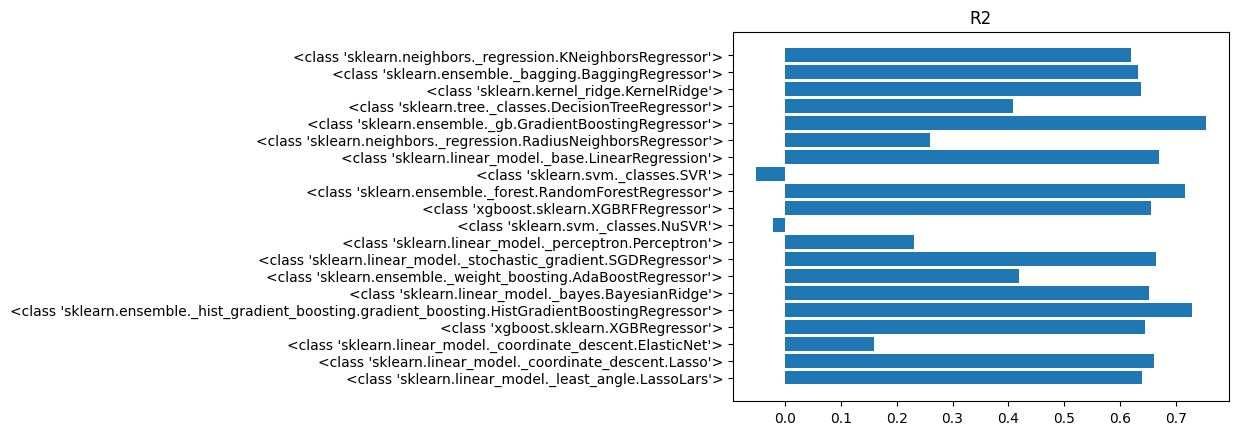

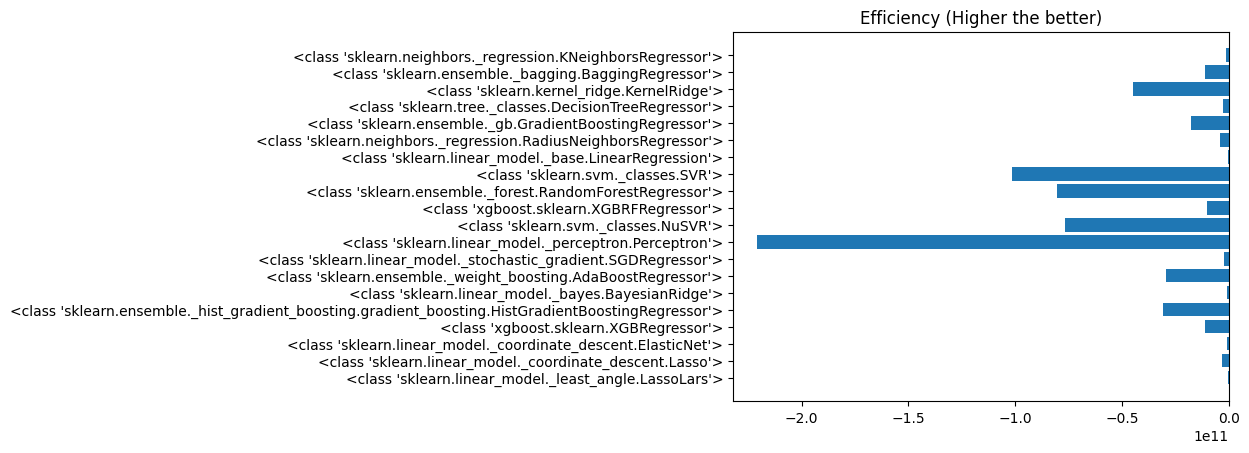

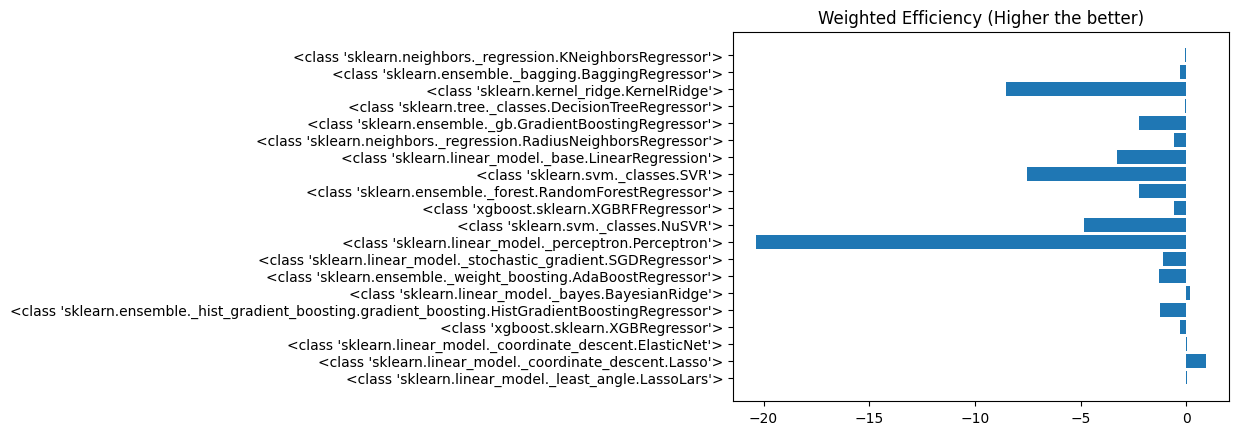

In [281]:
plot_results(housing_results)

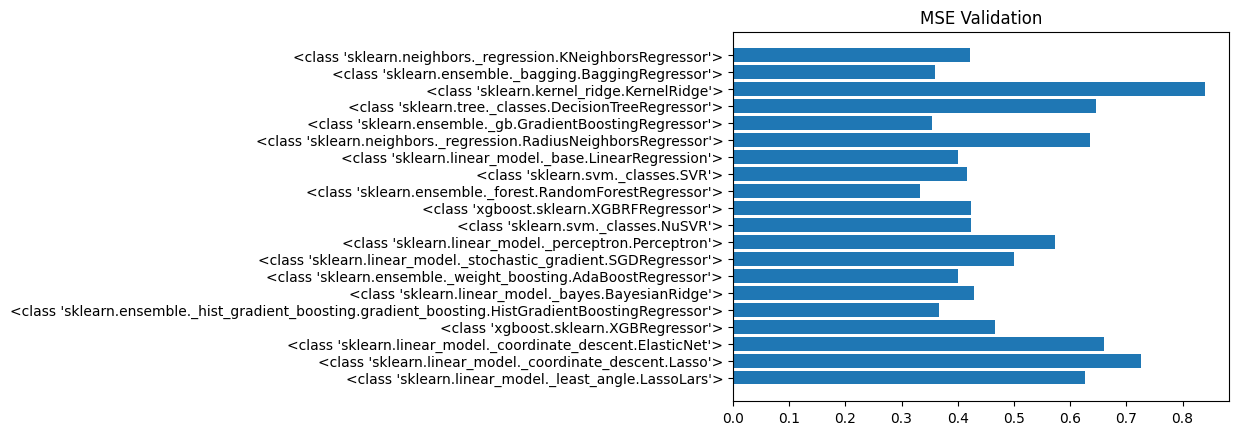

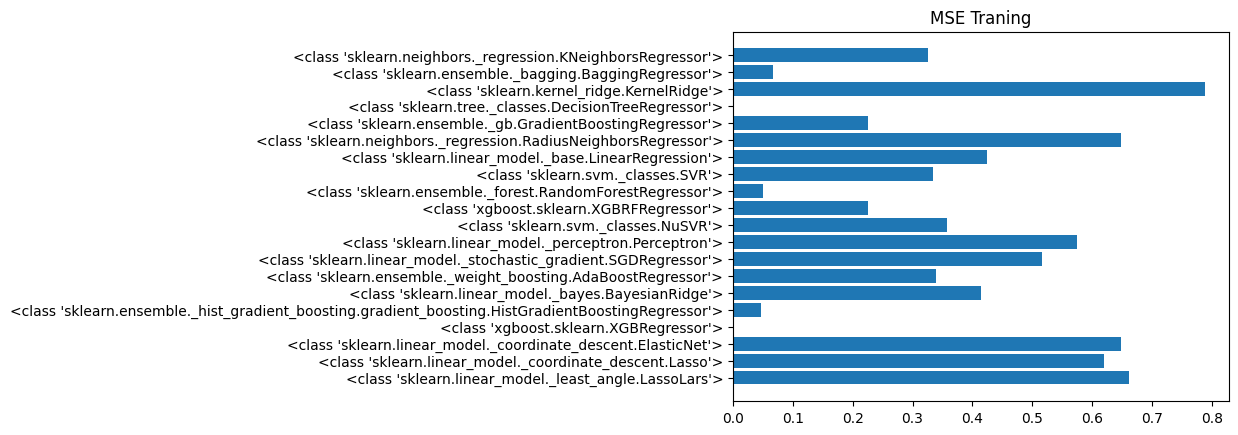

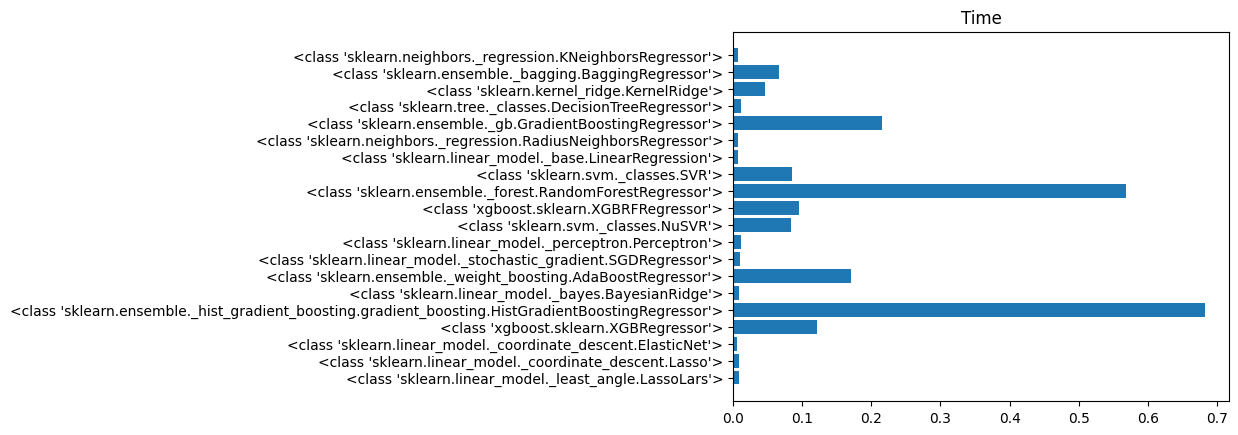

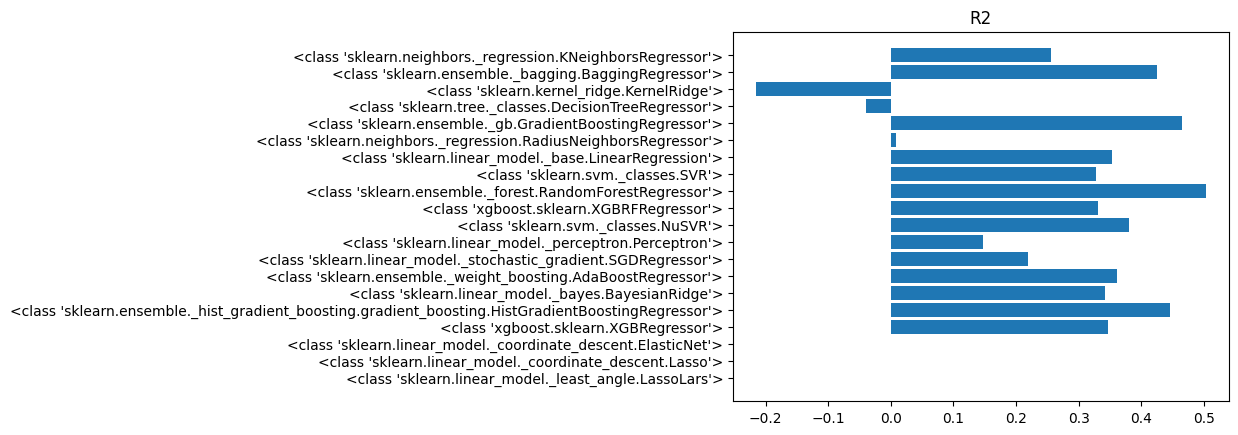

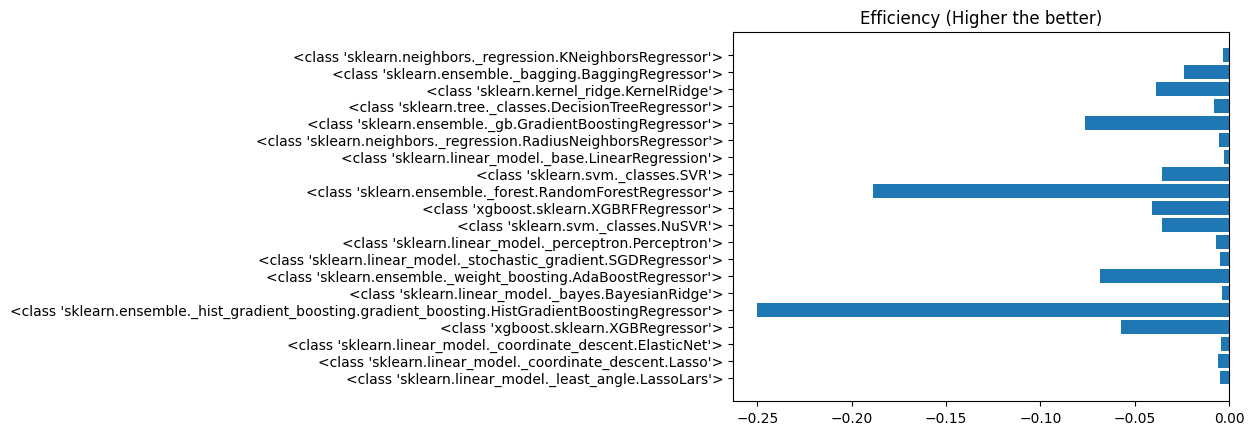

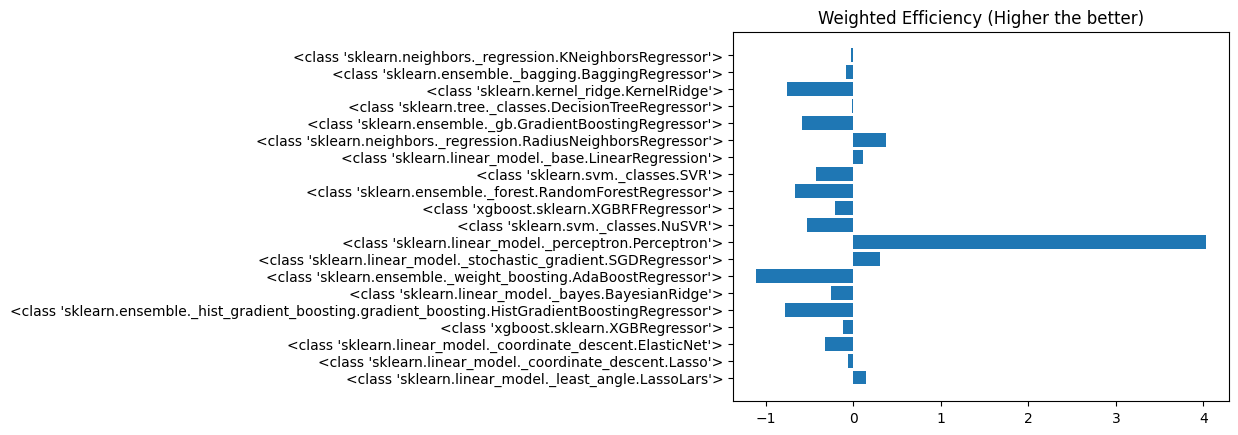

In [282]:
plot_results(quality_results)